In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import pickle #To use cifar-10

%matplotlib inline

In [2]:
#Load trainset_CIFAR_10
#https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle_trainset_CIFAR_10(file):
    dicts = dict()
    for i in range(1, 6):   #This dataset is divided into 5 files.
        if i == 1:
            file_dict = pickle.load(open(file + str(i), 'rb'), encoding = 'bytes')
            dicts[b'data'] = file_dict[b'data']
            dicts[b'labels'] = file_dict[b'labels']
        else:
            file_dict = pickle.load(open(file + str(i), 'rb'), encoding = 'bytes')
            dicts[b'data'] = np.concatenate((dicts[b'data'], file_dict[b'data']))
            dicts[b'labels'] += file_dict[b'labels']
    return dicts

#Load testset_CIFAR_10
def unpickle_testset_CIFAR_10(file):
    dicts = pickle.load(open(file, 'rb'), encoding = 'bytes')
    return dicts

#Load MNIST
#http://yann.lecun.com/exdb/mnist/
def unpickle_MNIST(image, label):
    #Read Image data
    image_set = open(image, 'rb')
    magic_number = struct.unpack(">i", image_set.read(4))[0]
    number_images = struct.unpack(">i", image_set.read(4))[0]
    rows = struct.unpack(">i", image_set.read(4))[0]
    cols = struct.unpack(">i", image_set.read(4))[0]
    image_set_data = np.reshape(np.fromstring(image_set.read(), dtype = np.uint8), (number_images, rows * cols))
    image_set.close()
    #Read Label data
    label_set = open(label, 'rb')
    magic_number = struct.unpack(">i", label_set.read(4))[0]
    number_of_items = struct.unpack(">i", label_set.read(4))[0]
    label_set_data = np.reshape(np.fromstring(label_set.read(), dtype = np.uint8), (number_of_items))
    label_set.close()    
    return image_set_data, label_set_data

In [3]:
def shuffle(X, y):
    """
    Argument:
    X -- all training_data
    y -- all training_label
    
    Return:
    X_train -- training_dataset
    y_train -- training_labelset
    X_cross -- cross_validation_dataset
    y_cross -- cross_validation_labelset
    """
    data_count = X.shape[0]
    shuffle_order = np.arange(data_count)
    np.random.shuffle(shuffle_order)
    X_train, y_train = X[shuffle_order][:(7 * data_count) // 10], y[shuffle_order][:(7 * data_count) // 10]
    X_cross, y_cross = X[shuffle_order][(7 * data_count) // 10:], y[shuffle_order][(7 * data_count) // 10:]
    return X_train, y_train, X_cross, y_cross

In [4]:
#Support Vector Machine Classifier
class Support_vector_machine():
    def __init__(self):
        pass
    
    def train(self, X_train, y_train, learning_rate = 0.1, iterations = 5000, check = False):
        """
        Argument:
        X_train -- training_data
        y_train -- training_label
        learning_rate -- learning_rate(alpha) of gradient descent. default value is 0.1
        iterations -- number of iterations of the optimization loop. default value is 5000
        check -- if check is True, check the analytic gradient through a numerical gradient. default value is False

        Store:
        W -- weights matrix
        b -- bias vector(1-dimension matrix)
        errorindex, error -- save value of iterations(index), save value of loss functions.         
        """
        self.X_train = X_train
        self.y_train = y_train
        pixelcount = self.X_train.shape[1]
        kindofclass = 10
        #initialize W, b
        self.W = np.random.randn(pixelcount, kindofclass).astype(np.float64)
        self.b = np.zeros(kindofclass).astype(np.float64)
        self.errorindex = []
        self.error = []
        for i in range(1, iterations + 1):
            # Getting classifier matrix
            svm_matrix = self.lossfun(self.W, self.b)
            if i % 200 == 0:
                print(i, "iterations finished")
                svm_error = (np.sum(svm_matrix)) / self.X_train.shape[0]
                self.errorindex.append(i)
                self.error.append(svm_error)
            # Find gradient
            dW, db = self.gradient(svm_matrix)
            if check == True:
                self.gradient_check()
                if i == 3:
                    check = False
                print("derivation", dW[:3, :3], db[:3])
            # update W, b
            self.W = self.W - learning_rate * (1 / i) * dW #(1 / i -> learning_rate decay)
            self.b = self.b - learning_rate * (1 / i) * db
    
    def lossfun(self, W, b):
        """
        Argument:
        X_train -- training_data
        y_train -- training_label
        W -- weights matrix
        b -- bias vector(1-dimension matrix)
        
        Return:
        svm_matrix -- matrix which applied svm classifier.
        """
        # svm -> max(0, Sj - Sy + 1) (j != y)
        value = (np.matmul(self.X_train, W) + b)
        
        # y_value -> to getting Sy
        y_value = value[range(value.shape[0]), self.y_train]
        
        # now svm_matrix -> max(0, Sj - Sy + 1)
        svm_matrix = np.maximum(0, value.T - y_value + 1).T
        
        # Makes matrix value which index equals to j == y to 0, because that value is 1. (Sj - Sy + 1 = 1, if, y == j)
        svm_matrix[np.arange(svm_matrix.shape[0]), self.y_train] = 0
        return svm_matrix

    def gradient(self, svm_matrix):
        """
        Argument:
        svm_matrix -- matrix which applied svm classifier.
        
        Return:
        dW -- gradient matrix about W.
        db -- gradient matrix about b.
        """
        # if svm_matrix value equals to 0, dL/dSj = 0; else, dL/dSj = 1
        morethen0 = (svm_matrix > 0).astype(np.float64)
        minus_value = np.sum(morethen0, axis = 1)
        # To calculate dL/dSy. That value is (-1) * (sum of vector morethan 0).
        morethen0[np.arange(minus_value.shape[0]), self.y_train] -= minus_value
        # Backpropagation
        dW = np.matmul(self.X_train.T, morethen0)
        db = np.sum(morethen0, axis = 0)
        return dW / self.X_train.shape[0], db / self.X_train.shape[0]
    
    def gradient_check(self, h = 0.00001):
        """
        Argument:
        h -- very small positive number, default value is 0.00001.
        """
        # Use dy/dx = lim(x->0)(f(x + h) - f(x - h) / (2 * h))        
        # numerical gradient_check
        dW = np.zeros(self.W.shape)
        db = np.zeros(self.b.shape)
        for i in range(3):
            for j in range(3):
                self.W[i][j] += h
                svm_matrix1 = self.lossfun(self.W, self.b)
                loss1 = (np.sum(svm_matrix1)) / self.X_train.shape[0]
                self.W[i][j] -= 2 * h
                svm_matrix2 = self.lossfun(self.W, self.b)
                loss2 = (np.sum(svm_matrix2)) / self.X_train.shape[0]
                dW[i][j] = (loss1 - loss2) / (2 * h)
                self.W[i][j] += h
        for i in range(3):
            self.b[i] += h
            svm_matrix1 = self.lossfun(self.W, self.b)
            loss1 = (np.sum(svm_matrix1)) / self.X_train.shape[0]
            self.b[i] -= 2 * h
            svm_matrix2 = self.lossfun(self.W, self.b)
            loss2 = (np.sum(svm_matrix2)) / self.X_train.shape[0]
            db[i] = (loss1 - loss2) / (2 * h)
            self.b[i] += h
        print("numerical", dW[:3, :3], db[:3])
    
    def predict(self, X_test):
        """
        Argument:
        X_test -- test_data
        
        Return:
        constant_value -- predicted label number
        """
        value = np.matmul(X_test, self.W) + self.b
        return value.argmax(axis = 1)
    
    def cross_validation(self, X_cross, y_cross):
        return
    
    def accuracy(self, X_test, y_test):
        """
        Argument:
        X_test -- test_data
        y_test -- test_label
        
        Return:
        value -- accuracy of classifier
        """
        value = np.mean(self.predict(X_test) == y_test) * 100
        return value

In [8]:
# MNIST
train_image_name = "mnist\\train-images.idx3-ubyte"
train_label_name = "mnist\\train-labels.idx1-ubyte"
test_image_name = "mnist\\t10k-images.idx3-ubyte"
test_label_name = "mnist\\t10k-labels.idx1-ubyte"

X, y = unpickle_MNIST(train_image_name, train_label_name)
X_train, y_train, X_cross, y_cross = shuffle(X, y)
X_test, y_test = unpickle_MNIST(test_image_name, test_label_name)

SVM_mnist = Support_vector_machine()
SVM_mnist.train(X_train[:1500], y_train[:1500], iterations = 5000, check = True)


numerical [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]] [ 0.1686667   0.23933353 -0.20933348]
derivation [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]] [ 0.16866667  0.23933333 -0.20933333]
numerical [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]] [-0.32266835 -0.40933373  0.40867017]
derivation [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]] [-0.32266667 -0.40933333  0.40866667]
numerical [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]] [ 0.1346667  -0.25933332  0.11800039]
derivation [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]] [ 0.13466667 -0.25933333  0.118     ]
200 iterations finished
400 iterations finished
600 iterations finished
800 iterations finished
1000 iterations finished
1200 iterations finished
1400 iterations finished
1600 iterations finished
1800 iterations finished
2000 iterations finished
2200 iterations finished
2400 iterations finished
2600 iterations finished
2800 iterations finished
3000 iterations finished
3200 iterations finished
3400 iterations finished
3600 iterati

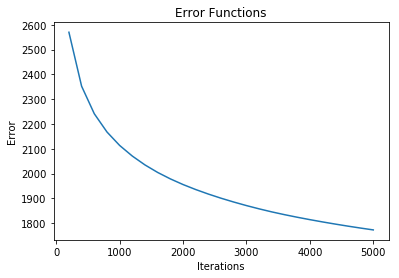

In [9]:
#Visualizing Error Curve
plt.plot(SVM_mnist.errorindex, SVM_mnist.error)
plt.title("Error Functions")
plt.xlabel('Iterations')
plt.ylabel('Error')

In [10]:
print("Test set accuracy is ", SVM_mnist.accuracy(X_test, y_test))
print("Train set accuracy is ", SVM_mnist.accuracy(X_train[:100], y_train[:100]))


Test set accuracy is  86.25
Train set accuracy is  80.0


Number of this picture is 2


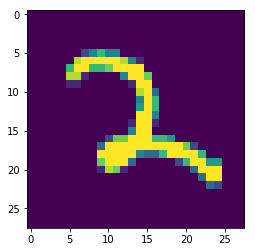

In [11]:
#Visualizing MNIST
X = X_train.reshape(42000, 28, 28)
i = np.random.choice(range(len(X)))
plt.imshow(X[i], interpolation = 'nearest')
print("Number of this picture is", y_train[i])

In [ ]:
#CIFAR_10
file_name = 'cifar-10\data_batch_'
datadict = unpickle_trainset_CIFAR_10(file_name)
file_name = 'cifar-10\\test_batch'
testdict = unpickle_testset_CIFAR_10(file_name)
classlist = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

X, y = datadict[b'data'], np.array(datadict[b'labels'])
X_train, y_train, X_cross, y_cross = shuffle(X, y)
X_test, y_test = testdict[b'data'], np.array(testdict[b'labels'])

a = Support_vector_machine()
a.train(X_train, y_train, iterations = 500)

In [ ]:
plt.plot(a.errorindex, a.error)

plt.title("Error Functions")
plt.xlabel('Iterations')
plt.ylabel('Error')

In [ ]:
print(a.accuracy(X_test, y_test))
print(a.accuracy(X_train, y_train))

In [ ]:
X = X_train.reshape(40000, 3, 32, 32).transpose(0, 2, 3, 1).astype("uint8")
Y = np.array(y_train)

#Visualizing CIFAR 10
i = np.random.choice(range(len(X)))
k = np.random.choice(range(1, 100))
plt.imshow(X[i], interpolation='nearest')
print("class is", classlist[Y[i]], Y[i])